# Capstone Project - The Battle of Neighborhoods

### Introduction

New York City's demographics show that it is a large and ethnically diverse metropolis. It is the largest city in the United States with a long history of international immigration. New York City was home to over 8.3 million people in 2019, accounting for over 40% of the population of New York State and a slightly lower percentage of the New York metropolitan area, home to approximately 23.6 million. Over the last decade the city has been growing faster than the region. The New York region continues to be by far the leading metropolitan gateway for legal immigrants admitted into the United States.  

Throughout its history, New York City has been a major point of entry for immigrants; the term "melting pot" was coined to describe densely populated immigrant neighbourhoods on the Lower East Side. As many as 800 languages are spoken in New York, making it the most linguistically diverse city in the world. English remains the most widely spoken language, although there are areas in the outer boroughs in which up to 25% of people speak English as an alternate language, and/or have limited or no English language fluency. English is least spoken in neighbourhoods such as Flushing, Sunset Park, and Corona.  

With its diverse culture, comes diverse food items. There are many restaurants in New York City, each belonging to different categories like Chinese, Indian , French etc.  

So, as part of this project, we will list and visualise all major parts of New York City that has great Chinese restaurants


### Data 
For this project we need the following data :
<ul>
<li> New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude.
    <ul>
        <li>Data source : https://cocl.us/new_york_dataset
        <li> Description : This data set contains the required information. And we will use this data set to explore various neighborhoods of new york city.
     </ul>
<li> Chinese resturants in each neighborhood of new york city.
        <ul>
        <li>Data source : Fousquare API
        <li> Description : By using this api we will get all the venues in each neighborhood. We can filter these venues to get only indian resturants.
     </ul>
<li> GeoSpace data
          <ul>
        <li>Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
        <li> Description : By using this geo space data we will get the New york Borough boundaries that will help us visualize choropleth map.
  
</ul>

### Approach
- Collect the new york city data from https://cocl.us/new_york_dataset
- Using FourSquare API we will find all venues for each neighborhood.
- Filter out all venues that are Indian Resturants.
- Find rating , tips and like count for each Chinese Resturants using FourSquare API.
- Using rating for each resturant , we will sort that data.
- Visualize the Ranking of neighborhoods using folium library(python)

### Questions that can be asked using the above mentioned datasets
- What is best location in New York City for Chinese Cuisine ? 
- Which areas have potential Indian Resturant Market ? 
- Which all areas lack Chinese Resturants ?
- Which is the best place to stay if I prefer Chinese Cuisine ?

### Analysis

We will import the required libraries for python.

- pandas and numpy for handling data.
- request module for using FourSquare API.
- geopy to get co-ordinates of City of New York.
- folium to visualize the results on a map

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
import json
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given  latitude and longitude. Below function will return us the venue id , venue name and category.

In [3]:
def get_venues(lat,lng):
    
    #set variables
    radius=2000
    LIMIT=100
    CLIENT_ID = '1MLBQOKWQJVE5T011ZDGSH2D34JJBVNYNSUGWAKTDRCG3J4T' # your Foursquare ID
    CLIENT_SECRET = 'LJGVE4EYAMYNUNO42JISWVGLVARK1V3BL2X5VECXP2SBE3FQ' # your Foursquare Secret

    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df
    

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id.
This will be used for ranking.

In [17]:
def get_venue_details(venue_id):
        
    CLIENT_ID = '1MLBQOKWQJVE5T011ZDGSH2D34JJBVNYNSUGWAKTDRCG3J4T' # your Foursquare ID
    CLIENT_SECRET = 'LJGVE4EYAMYNUNO42JISWVGLVARK1V3BL2X5VECXP2SBE3FQ' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [5]:
def get_new_york_data():
    
    json_dict = {}
    with open('nyu_2451_34572.json') as json_data:
        json_dict = json.load(json_data)
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    # all data is present in features label
    for data in json_dict['features']:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

We will call the above funtion to get the new york city data.

In [6]:
# get new york data
new_york_df=get_new_york_data()

In [7]:
new_york_df.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [8]:
new_york_df.shape

(306, 4)

So there are total of 306 different Neighborhoods in New York

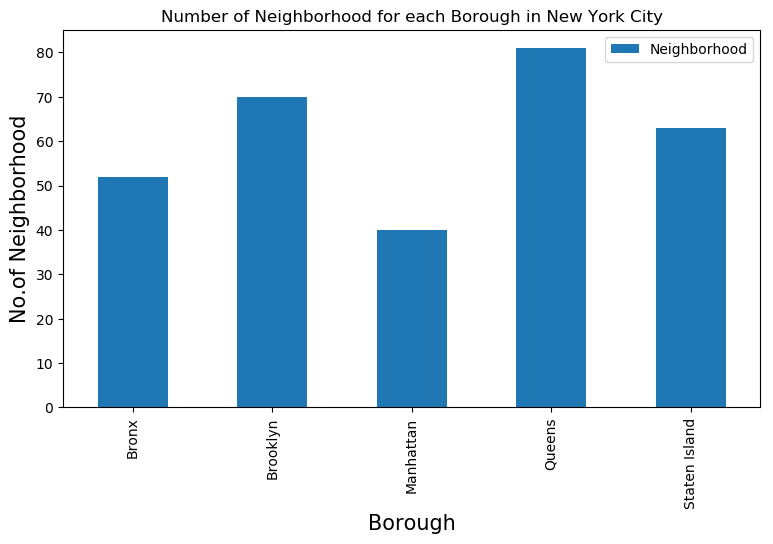

In [9]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_df.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Queens has highest number of neighborhoods

Now we will collect Chinese resturants for each Neighborhood

In [18]:
# prepare neighborhood list that contains Chinese resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
chinese_restaurant_df=pd.DataFrame(columns=column_names)
count=1
for row in new_york_df.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    restaurants=venues[venues['Category']=='Chinese Restaurant']   
    print('(',count,'/',len(chinese_restaurant_df),')','Chinese Restaurant in '+Neighborhood+', '+Borough+':'+str(len(restaurants)))
    for restaurant in restaurants.values.tolist():
        id, name , category=restaurant
        chinese_restaurant_df = chinese_restaurant_df.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 0 ) Chinese Restaurant in Wakefield, Bronx:1
( 2 / 1 ) Chinese Restaurant in Co-op City, Bronx:0
( 3 / 1 ) Chinese Restaurant in Eastchester, Bronx:0
( 4 / 1 ) Chinese Restaurant in Fieldston, Bronx:0
( 5 / 1 ) Chinese Restaurant in Riverdale, Bronx:0
( 6 / 1 ) Chinese Restaurant in Kingsbridge, Bronx:0
( 7 / 1 ) Chinese Restaurant in Marble Hill, Manhattan:0
( 8 / 1 ) Chinese Restaurant in Woodlawn, Bronx:0
( 9 / 1 ) Chinese Restaurant in Norwood, Bronx:1
( 10 / 2 ) Chinese Restaurant in Williamsbridge, Bronx:0
( 11 / 2 ) Chinese Restaurant in Baychester, Bronx:0
( 12 / 2 ) Chinese Restaurant in Pelham Parkway, Bronx:2
( 13 / 4 ) Chinese Restaurant in City Island, Bronx:1
( 14 / 5 ) Chinese Restaurant in Bedford Park, Bronx:0
( 15 / 5 ) Chinese Restaurant in University Heights, Bronx:1
( 16 / 6 ) Chinese Restaurant in Morris Heights, Bronx:2
( 17 / 8 ) Chinese Restaurant in Fordham, Bronx:1
( 18 / 9 ) Chinese Restaurant in East Tremont, Bronx:1
( 19 / 10 ) Chinese Restaurant in 

( 143 / 145 ) Chinese Restaurant in Maspeth, Queens:0
( 144 / 145 ) Chinese Restaurant in Ridgewood, Queens:0
( 145 / 145 ) Chinese Restaurant in Glendale, Queens:2
( 146 / 147 ) Chinese Restaurant in Rego Park, Queens:3
( 147 / 150 ) Chinese Restaurant in Woodhaven, Queens:1
( 148 / 151 ) Chinese Restaurant in Ozone Park, Queens:4
( 149 / 155 ) Chinese Restaurant in South Ozone Park, Queens:4
( 150 / 159 ) Chinese Restaurant in College Point, Queens:3
( 151 / 162 ) Chinese Restaurant in Whitestone, Queens:1
( 152 / 163 ) Chinese Restaurant in Bayside, Queens:1
( 153 / 164 ) Chinese Restaurant in Auburndale, Queens:0
( 154 / 164 ) Chinese Restaurant in Little Neck, Queens:3
( 155 / 167 ) Chinese Restaurant in Douglaston, Queens:3
( 156 / 170 ) Chinese Restaurant in Glen Oaks, Queens:0
( 157 / 170 ) Chinese Restaurant in Bellerose, Queens:2
( 158 / 172 ) Chinese Restaurant in Kew Gardens Hills, Queens:2
( 159 / 174 ) Chinese Restaurant in Fresh Meadows, Queens:1
( 160 / 175 ) Chinese Re

( 278 / 333 ) Chinese Restaurant in Sunnyside Gardens, Queens:3
( 279 / 336 ) Chinese Restaurant in Blissville, Queens:0
( 280 / 336 ) Chinese Restaurant in Fulton Ferry, Brooklyn:1
( 281 / 337 ) Chinese Restaurant in Vinegar Hill, Brooklyn:1
( 282 / 338 ) Chinese Restaurant in Weeksville, Brooklyn:1
( 283 / 339 ) Chinese Restaurant in Broadway Junction, Brooklyn:1
( 284 / 340 ) Chinese Restaurant in Dumbo, Brooklyn:1
( 285 / 341 ) Chinese Restaurant in Manor Heights, Staten Island:2
( 286 / 343 ) Chinese Restaurant in Willowbrook, Staten Island:2
( 287 / 345 ) Chinese Restaurant in Sandy Ground, Staten Island:1
( 288 / 346 ) Chinese Restaurant in Egbertville, Staten Island:0
( 289 / 346 ) Chinese Restaurant in Roxbury, Queens:0
( 290 / 346 ) Chinese Restaurant in Homecrest, Brooklyn:1
( 291 / 347 ) Chinese Restaurant in Middle Village, Queens:1
( 292 / 348 ) Chinese Restaurant in Prince's Bay, Staten Island:1
( 293 / 349 ) Chinese Restaurant in Lighthouse Hill, Staten Island:0
( 294 /

Now that we have got all the indian resturants in new york city , we will analyze it

In [19]:
chinese_restaurant_df.head()

Borough    Neighborhood                        ID  \
0   Bronx       Wakefield  4edbac4e775bcc53fc0ed5f8   
1   Bronx         Norwood  4e2e08021838f1c552b6b8eb   
2   Bronx  Pelham Parkway  4b9d6b45f964a52078ab36e3   
3   Bronx  Pelham Parkway  4c3f7f2eda3dc928b8f6c5b9   
4   Bronx     City Island  4bfc652bf14fa593c1f5c9d4   

                             Name  
0            Hong Kong China King  
1  Choi Yuan - Chinese Restaurant  
2      Mr. Q's Chinese Restaurant  
3                  Peking Kitchen  
4   City Island Chinese Resturant

In [20]:
chinese_restaurant_df.shape

(371, 4)

We got 371 Chinese Resturants across New York City

Lets save the Donut records in CSV, as there is a daily limitations in reading these records

In [21]:
chinese_restaurant_df.to_csv('ChineseRestaurant.csv', index=False)

In [22]:
chinese_restaurant_df = pd.read_csv('ChineseRestaurant.csv')

In [23]:
# Revalidate the df size
chinese_restaurant_df.shape

(371, 4)

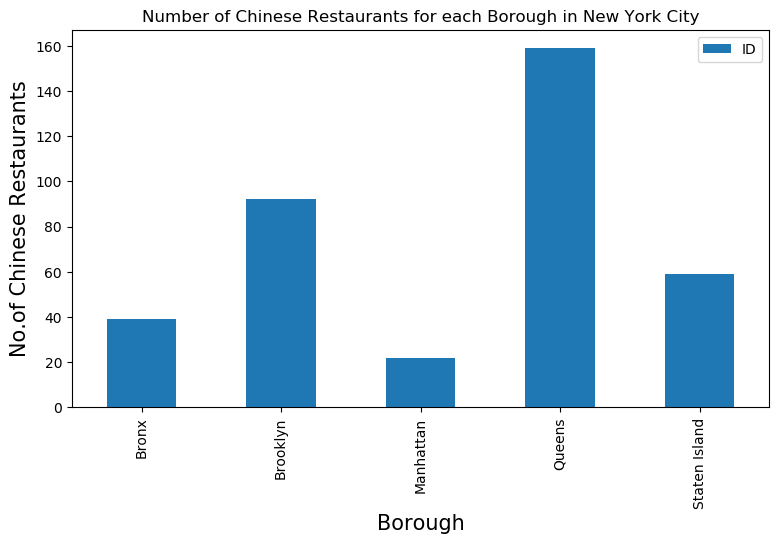

In [24]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Chinese Restaurants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Chinese Restaurants', fontsize=15)
#giving a bar plot
chinese_restaurant_df.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Queens has the largest number of Chinese resturants

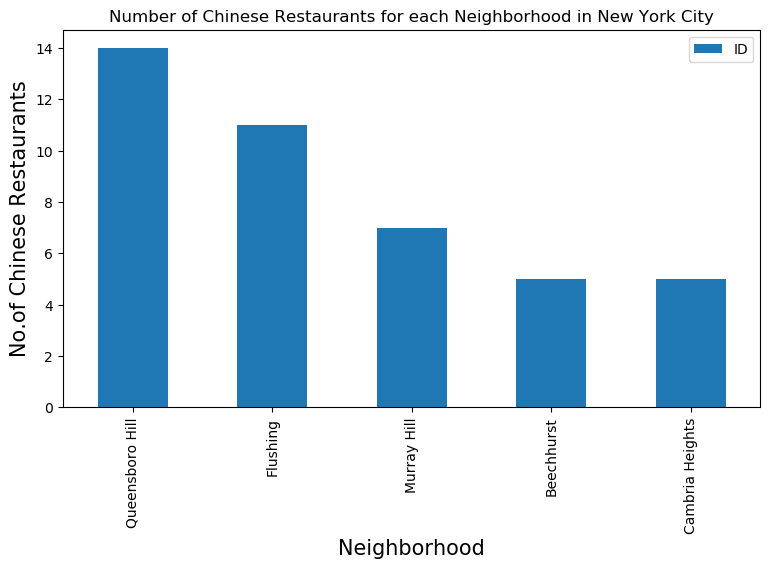

In [25]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Chinese Restaurants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Chinese Restaurants', fontsize=15)
#giving a bar plot
chinese_restaurant_df.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [26]:
len(chinese_restaurant_df[chinese_restaurant_df['Neighborhood']=='Queensboro Hill'])

14

So Queensboro Hill in Queens has the highest number of Chinese Resturants with a total count of 14.

Now we will get the ranking of each resturant for further analysis.

In [30]:
#venue_details=get_venue_details(ID)
venue_details

ID               Name  Likes  Rating  Tips
0  4c7e9ddafb13a1cdf5369ea4  El Pabelon De Oro     15     7.6     8

In [32]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
chinese_rest_ratings_df=pd.DataFrame(columns=column_names)
count=1


for restaurant in chinese_restaurant_df.values.tolist():
    Borough,Neighborhood,ID,Name=restaurant
    try:
        venue_details=get_venue_details(ID)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except (IndexError, KeyError):
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(chinese_restaurant_df),')','processed')
    chinese_rest_ratings_df = chinese_rest_ratings_df.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

No data available for id= 4edbac4e775bcc53fc0ed5f8
( 1 / 371 ) processed
( 2 / 371 ) processed
( 3 / 371 ) processed
( 4 / 371 ) processed
( 5 / 371 ) processed
( 6 / 371 ) processed
( 7 / 371 ) processed
( 8 / 371 ) processed
( 9 / 371 ) processed
( 10 / 371 ) processed
( 11 / 371 ) processed
( 12 / 371 ) processed
( 13 / 371 ) processed
( 14 / 371 ) processed
( 15 / 371 ) processed
No data available for id= 4e6d29a0b0fb273d16817e6c
( 16 / 371 ) processed
( 17 / 371 ) processed
( 18 / 371 ) processed
( 19 / 371 ) processed
( 20 / 371 ) processed
( 21 / 371 ) processed
No data available for id= 4e6d29a0b0fb273d16817e6c
( 22 / 371 ) processed
( 23 / 371 ) processed
( 24 / 371 ) processed
( 25 / 371 ) processed
( 26 / 371 ) processed
( 27 / 371 ) processed
( 28 / 371 ) processed
( 29 / 371 ) processed
( 30 / 371 ) processed
( 31 / 371 ) processed
( 32 / 371 ) processed
( 33 / 371 ) processed
( 34 / 371 ) processed
( 35 / 371 ) processed
( 36 / 371 ) processed
( 37 / 371 ) processed
( 38 

( 271 / 371 ) processed
( 272 / 371 ) processed
( 273 / 371 ) processed
No data available for id= 4c2bd58f57a9c9b6f591f667
( 274 / 371 ) processed
( 275 / 371 ) processed
No data available for id= 4c61edbf79d1e21ec70ad515
( 276 / 371 ) processed
( 277 / 371 ) processed
( 278 / 371 ) processed
( 279 / 371 ) processed
( 280 / 371 ) processed
( 281 / 371 ) processed
( 282 / 371 ) processed
No data available for id= 4e5181baa80997aa8a56666f
( 283 / 371 ) processed
( 284 / 371 ) processed
( 285 / 371 ) processed
( 286 / 371 ) processed
( 287 / 371 ) processed
( 288 / 371 ) processed
( 289 / 371 ) processed
( 290 / 371 ) processed
No data available for id= 4e5181baa80997aa8a56666f
( 291 / 371 ) processed
No data available for id= 4c2525bd136d20a10913e361
( 292 / 371 ) processed
( 293 / 371 ) processed
No data available for id= 4cc61c46b2beb1f74faa264c
( 294 / 371 ) processed
( 295 / 371 ) processed
( 296 / 371 ) processed
No data available for id= 4bb7d282b35776b0b83dc801
( 297 / 371 ) proce

In [33]:
chinese_rest_ratings_df.head()

Borough    Neighborhood                        ID  \
0   Bronx       Wakefield                         0   
1   Bronx         Norwood  4e2e08021838f1c552b6b8eb   
2   Bronx  Pelham Parkway  4b9d6b45f964a52078ab36e3   
3   Bronx  Pelham Parkway  4c3f7f2eda3dc928b8f6c5b9   
4   Bronx     City Island  4bfc652bf14fa593c1f5c9d4   

                             Name Likes Rating Tips  
0                               0     0      0    0  
1  Choi Yuan - Chinese Restaurant     6    6.9    7  
2      Mr. Q's Chinese Restaurant     9    7.4   10  
3                  Peking Kitchen     9    7.6    2  
4   City Island Chinese Resturant     6    6.3    4

In [34]:
chinese_rest_ratings_df.shape

(371, 7)

In [35]:
chinese_restaurant_df.shape

(371, 4)

So we got data for all resturants
Now lets save this data to a csv sheet. In case we by mistake modify it.
As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required

In [36]:
chinese_rest_ratings_df.to_csv('chineseRestaurantsRating.csv', index=False)

Lets verify the data from saved csv file

In [37]:
chinese_rest_ratings_df=pd.read_csv('chineseRestaurantsRating.csv')

In [38]:
chinese_rest_ratings_df.shape

(371, 7)

In [39]:
chinese_rest_ratings_df.head()

Borough    Neighborhood                        ID  \
0   Bronx       Wakefield                         0   
1   Bronx         Norwood  4e2e08021838f1c552b6b8eb   
2   Bronx  Pelham Parkway  4b9d6b45f964a52078ab36e3   
3   Bronx  Pelham Parkway  4c3f7f2eda3dc928b8f6c5b9   
4   Bronx     City Island  4bfc652bf14fa593c1f5c9d4   

                             Name  Likes  Rating  Tips  
0                               0      0     0.0     0  
1  Choi Yuan - Chinese Restaurant      6     6.9     7  
2      Mr. Q's Chinese Restaurant      9     7.4    10  
3                  Peking Kitchen      9     7.6     2  
4   City Island Chinese Resturant      6     6.3     4

In [40]:
chinese_rest_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 7 columns):
Borough         371 non-null object
Neighborhood    371 non-null object
ID              371 non-null object
Name            371 non-null object
Likes           371 non-null int64
Rating          371 non-null float64
Tips            371 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 20.4+ KB


We see that values like Likes, Tips are strig values. We would need to convert them into float for further analysis

In [28]:
chinese_rest_ratings_df['Likes']=chinese_rest_ratings_df['Likes'].astype('float64')

In [29]:
chinese_rest_ratings_df['Tips']=chinese_rest_ratings_df['Tips'].astype('float64')

In [30]:
chinese_rest_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 7 columns):
Borough         40 non-null object
Neighborhood    40 non-null object
ID              40 non-null object
Name            40 non-null object
Likes           40 non-null float64
Rating          40 non-null float64
Tips            40 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.3+ KB


Now the data types looks correct

In [41]:
# Resturant with maximum Likes
chinese_rest_ratings_df.iloc[chinese_rest_ratings_df['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1488
Rating                               9.2
Tips                                 521
Name: 104, dtype: object

In [42]:
# Resturant with maximum Rating
chinese_rest_ratings_df.iloc[chinese_rest_ratings_df['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1488
Rating                               9.2
Tips                                 521
Name: 104, dtype: object

In [43]:
# Resturant with maximum Tips
chinese_rest_ratings_df.iloc[chinese_rest_ratings_df['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1488
Rating                               9.2
Tips                                 521
Name: 104, dtype: object

Now lets visualize neighborhood with maximum average rating of resturants

In [44]:
ny_neighborhood_stats=chinese_rest_ratings_df.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [45]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

Neighborhood  Average Rating
28             Chelsea            9.15
125               Noho            9.10
29           Chinatown            9.10
79          Greenpoint            9.10
185       West Village            9.10
55        East Village            9.10
100       Little Italy            9.10
174         Tudor City            9.10
56   East Williamsburg            9.10
102    Lower East Side            9.10

Above are the top neighborhoods with top average rating for Chinese resturants

In [46]:
ny_borough_stats=chinese_rest_ratings_df.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [47]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

Borough  Average Rating
2      Manhattan        8.609091
1       Brooklyn        7.698913
0          Bronx        6.828205
3         Queens        6.085535
4  Staten Island        4.535593

Similarly these are the average rating of Chinese Resturants for each Borough

Lets visualize it

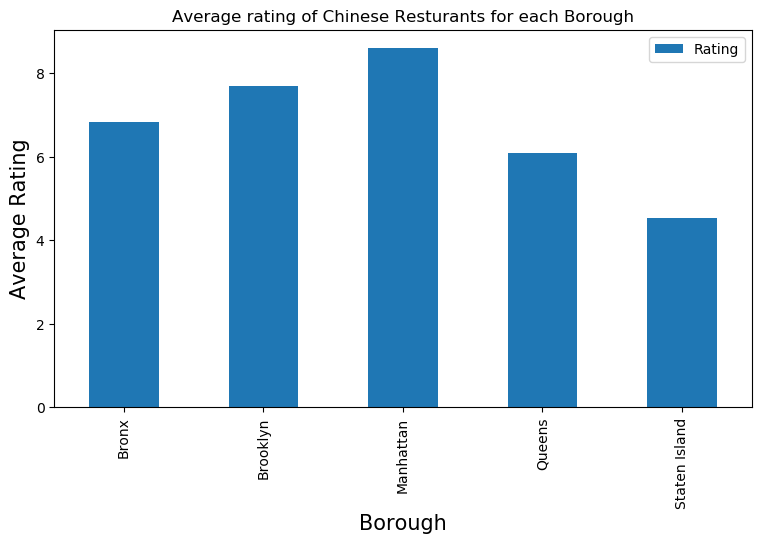

In [48]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Chinese Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
chinese_rest_ratings_df.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map

In [49]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]

In [50]:
ny_neighborhood_stats

Neighborhood  Average Rating
28             Chelsea            9.15
29           Chinatown            9.10
55        East Village            9.10
56   East Williamsburg            9.10
79          Greenpoint            9.10
100       Little Italy            9.10
102    Lower East Side            9.10
125               Noho            9.10
127         North Side            9.05
165         South Side            9.05
174         Tudor City            9.10
185       West Village            9.10
188       Williamsburg            9.05

We will join this dataset to original new york data to get longitude and latitude

In [52]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_df, on='Neighborhood')

In [53]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [54]:
ny_neighborhood_stats

Borough       Neighborhood   Latitude  Longitude  Average Rating
0       Manhattan            Chelsea  40.744035 -74.003116            9.15
1   Staten Island            Chelsea  40.594726 -74.189560            9.15
2       Manhattan          Chinatown  40.715618 -73.994279            9.10
3       Manhattan       East Village  40.727847 -73.982226            9.10
4        Brooklyn  East Williamsburg  40.708492 -73.938858            9.10
5        Brooklyn         Greenpoint  40.730201 -73.954241            9.10
6       Manhattan       Little Italy  40.719324 -73.997305            9.10
7       Manhattan    Lower East Side  40.717807 -73.980890            9.10
8       Manhattan               Noho  40.723259 -73.988434            9.10
9        Brooklyn         North Side  40.714823 -73.958809            9.05
10       Brooklyn         South Side  40.710861 -73.958001            9.05
11      Manhattan         Tudor City  40.746917 -73.971219            9.10
12      Manhattan       West Village  40.734434 -74.006180            9.10
13       Brooklyn       Williamsburg  40.707144 -73.958115            9.05

Now we will show this data on a map

In [55]:
# create map and display it
ny_map = folium.Map(location=[40.730610, -73.935242], zoom_start=12)

In [56]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the restaurants and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )


Lets add a new field to dataframe for labeling purpose

In [57]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [58]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

Now that we have visualized the Neighborhoods.
<br>Lets Visualize Boroughs based on average Rating

In [61]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=10)
ny_geo = r'Borough Boundaries.geojson'

ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
ny_map

C:\Users\vkavthek\AppData\Local\Continuum\anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


### Conclusion 
- Chelsea(Manhattan), Noho(Manhattan), Greenpoint(Brooklyn) are some of the best neighborhoods for Chinese cuisine. 
- Manhattan have potential Chinese Resturants Market
- Manhattan is the best place to stay if you prefer Chinese Cuisine.

### Limitations 
- The ranking is purely on basis of rating of resturants
- The accuracy of data depends purely depends on the data provided by FourSquare